# Spotify Track Recommender System with LightGCN

In [ ]:
folder_link = "https://drive.google.com/drive/folders/11EaHZrKOljp1ZRXRP9ZglLlJxQGT2Xo5?usp=drive_link"

In [ ]:
import re

In [ ]:
!pip install torch-geometric
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.4 MB/s eta 0:00:00


In [ ]:
# General libraries
import json
from pathlib import Path as Data_Path
import os
from os.path import isfile, join
import pickle
import random

import numpy as np
import networkx as nx
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

In [ ]:
# Import relevant ML libraries
from typing import Optional, Union

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Embedding, ModuleList, Linear
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch.nn.modules.loss import _Loss

from torch_geometric.nn.conv import LGConv, SAGEConv
from torch_geometric.typing import Adj, OptTensor, SparseTensor


We also set a random seed so that our work is reproducible!

In [ ]:

# set the seed for reproducibility
seed = 224
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
MAIN_DIR = "/content/drive/My Drive/SpotifyDataset" # https://drive.google.com/drive/folders/11EaHZrKOljp1ZRXRP9ZglLlJxQGT2Xo5?usp=drive_link
#p6772 = ""
DATA_DIR = Data_Path('spotify_million_playlist_dataset/data')
os.chdir(MAIN_DIR)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
with open(f"{DATA_DIR}/{os.listdir(DATA_DIR)[0]}") as jf:
  example_file = json.load(jf)

print(example_file['playlists'][0])

{'name': 'Throwbacks', 'collaborative': 'false', 'pid': 0, 'modified_at': 1493424000, 'num_tracks': 52, 'num_albums': 47, 'num_followers': 1, 'tracks': [{'pos': 0, 'artist_name': 'Missy Elliott', 'track_uri': 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI', 'artist_uri': 'spotify:artist:2wIVse2owClT7go1WT98tk', 'track_name': 'Lose Control (feat. Ciara & Fat Man Scoop)', 'album_uri': 'spotify:album:6vV5UrXcfyQD1wu4Qo2I9K', 'duration_ms': 226863, 'album_name': 'The Cookbook'}, {'pos': 1, 'artist_name': 'Britney Spears', 'track_uri': 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak', 'artist_uri': 'spotify:artist:26dSoYclwsYLMAKD3tpOr4', 'track_name': 'Toxic', 'album_uri': 'spotify:album:0z7pVBGOD7HCIB7S8eLkLI', 'duration_ms': 198800, 'album_name': 'In The Zone'}, {'pos': 2, 'artist_name': 'Beyoncé', 'track_uri': 'spotify:track:0WqIKmW4BTrj3eJFmnCKMv', 'artist_uri': 'spotify:artist:6vWDO969PvNqNYHIOW5v0m', 'track_name': 'Crazy In Love', 'album_uri': 'spotify:album:25hVFAxTlDvXbx2X2QkUkE', 'duration_ms': 2359

In [ ]:
class Track:

  def __init__(self, track_dict, playlist):
    self.uri = track_dict["track_uri"]
    self.name = track_dict["track_name"]
    self.artist_uri = track_dict["artist_uri"]
    self.artist_name = track_dict["artist_name"]
    self.playlist = playlist

  def __str__(self):
    return f"Track {self.uri} called {self.name} by {self.artist_uri} ({self.artist_name}) in playlist {self.playlist}."

  def __repr__(self):
    return f"Track {self.uri}"

class Playlist:

  def __init__(self, json_data, index):

    self.name = f"playlist_{index}"
    self.title = json_data["name"]
    self.data = json_data

    self.tracks = {}
    self.artists = []

  def load_tracks(self):

    tracks_list = self.data["tracks"]
    self.tracks = {x["track_uri"] : Track(x, self.name) for x in tracks_list}
    self.artists = [x["artist_uri"] for x in tracks_list]

  def __str__(self):
    return f"Playlist {self.name} with {len(self.tracks)} tracks loaded."

  def __repr__(self):
    return f"Playlist {self.name}"

class JSONFile:

  def __init__(self, data_path, file_name, start_index):

    self.file_name = file_name
    self.start_index = start_index

    with open(join(data_path, file_name)) as json_file:
      json_data = json.load(json_file)
    self.data = json_data

    self.playlists = {}

  def process_file(self):
    """ Call this function to load all of the playlists in the json data."""

    for i, playlist_json in enumerate(self.data["playlists"]):
      playlist = Playlist(playlist_json, self.start_index + i)
      playlist.load_tracks()
      self.playlists[playlist.name] = playlist

  def __str__(self):
    return f"JSON {self.file_name} has {len(self.playlists)} playlists loaded."

  def __repr__(self):
    return self.file_name


Load files

In [ ]:
DATA_PATH = Data_Path('spotify_million_playlist_dataset/data')
N_FILES_TO_USE = 30

file_names = sorted(os.listdir(DATA_PATH))
file_names_to_use = file_names[:N_FILES_TO_USE]

n_playlists = 0

# load each json file, and store it in a list of files
JSONs = []
for file_name in tqdm(file_names_to_use, desc='Files processed: ', unit='files', total=len(file_names_to_use)):
  json_file = JSONFile(DATA_PATH, file_name, n_playlists)
  json_file.process_file()
  n_playlists += len(json_file.playlists)
  JSONs.append(json_file)

Files processed:   0%|          | 0/30 [00:00<?, ?files/s]

In [ ]:
playlist_data = {}
playlists = []
tracks = []

# build list of all unique playlists, tracks
for json_file in tqdm(JSONs):
  playlists += [p.name for p in json_file.playlists.values()]
  tracks += [track.uri for playlist in json_file.playlists.values() for track in list(playlist.tracks.values())]
  playlist_data = playlist_data | json_file.playlists

  0%|          | 0/30 [00:00<?, ?it/s]



Graph Creation

In [ ]:
## create graph from these lists

# adding nodes
G = nx.Graph()
G.add_nodes_from([
    (p, {'name':p, "node_type" : "playlist"}) for p in playlists
])
G.add_nodes_from([
    (t, {'name':t, "node_type" : "track"}) for t in tracks
])

# adding edges
edge_list = []
for p_name, playlist in playlist_data.items():
  edge_list += [(p_name, t) for t in playlist.tracks]
G.add_edges_from(edge_list)

print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges())

Num nodes: 368020 . Num edges: 1983411


kcore, remove the others with less connections

In [ ]:
kcore = 20
G = nx.k_core(G, kcore)

## Constructing a graph dataset

In order to use our graph with the graph. machine learning packages we

---

installed, we need to do a bit of processing of the graph first.

In [ ]:
print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges())

Num nodes: 31194 . Num edges: 1078584


In [ ]:
n_nodes, n_edges = G.number_of_nodes(), G.number_of_edges()

# by sorting them we get an ordering playlist1, ..., playlistN, track1, ..., trackN
sorted_nodes = sorted(list(G.nodes()))

# create dictionaries to index to 0 to n_nodes, will be necessary for when we are using tensors
node2id = dict(zip(sorted_nodes, np.arange(n_nodes)))
id2node = dict(zip(np.arange(n_nodes), sorted_nodes))

G = nx.relabel_nodes(G, node2id)

# also keep track of how many playlists, tracks we have
playlists_idx = [i for i, v in enumerate(node2id.keys()) if "playlist" in v]
tracks_idx = [i for i, v in enumerate(node2id.keys()) if "track" in v]

n_playlists = np.max(playlists_idx) + 1
n_tracks = n_nodes - n_playlists

n_playlists, n_tracks

(18084, 13110)

In [ ]:
n_playlists + n_tracks

31194

In [ ]:
import torch
import numpy as np
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit

# Define nodes and edges
edge_idx = torch.tensor(np.array(G.edges()).T, dtype=torch.long)
num_nodes = max(edge_idx.max().item() + 1, n_playlists + n_tracks)

# Ensure edge_index is in the correct shape
print("Edge index shape:", edge_idx.shape)  # Should be [2, num_edges]

# Create the PyG Data object
graph_data = Data(edge_index=edge_idx, num_nodes=num_nodes)

# Validate num_nodes
print("Number of nodes:", graph_data.num_nodes)

# Convert to train/val/test splits
transform = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=0,
    num_val=0.15,
    num_test=0.15
)

# Apply the transform
try:
    train_split, val_split, test_split = transform(graph_data)
    print("Train split:", train_split)
    print("Validation split:", val_split)
    print("Test split:", test_split)
except IndexError as e:
    print("Error during splitting:", e)


Edge index shape: torch.Size([2, 1078584])
Number of nodes: 31194
Train split: Data(edge_index=[2, 755190], num_nodes=31194, edge_label=[377595], edge_label_index=[2, 377595])
Validation split: Data(edge_index=[2, 755190], num_nodes=31194, edge_label=[80912], edge_label_index=[2, 80912])
Test split: Data(edge_index=[2, 917014], num_nodes=31194, edge_label=[80912], edge_label_index=[2, 80912])


In [ ]:
print(graph_data.num_nodes)  # Should match the total number of nodes
print(graph_data.edge_index)  # Should match the total number of nodes

31194
tensor([[  919,   919,   919,  ..., 23447, 28888,  9731],
        [23137, 21763, 19284,  ...,  9731, 15575, 21008]])


In [ ]:
num_nodes

31194

Get splits by message-passing (`edge_index` and target edges (`edge_label_index`).

In [ ]:
graph_data

Data(edge_index=[2, 1078584], num_nodes=31194)

In [ ]:
# note these are stored as float32, we need them to be int64 for future training

# Edge index: message passing edges
train_split.edge_index = train_split.edge_index.type(torch.int64)
val_split.edge_index = val_split.edge_index.type(torch.int64)
test_split.edge_index = test_split.edge_index.type(torch.int64)
# Edge label index: supervision edges
train_split.edge_label_index = train_split.edge_label_index.type(torch.int64)
val_split.edge_label_index = val_split.edge_label_index.type(torch.int64)
test_split.edge_label_index = test_split.edge_label_index.type(torch.int64)

In [ ]:
print(f"Train set has {train_split.edge_label_index.shape[1]} positives supervision edges")
print(f"Validation set has {val_split.edge_label_index.shape[1]} positive supervision edges")
print(f"Test set has {test_split.edge_label_index.shape[1]} positive supervision edges")

print(f"Train set has {train_split.edge_index.shape[1]} message passing edges")
print(f"Validation set has {val_split.edge_index.shape[1]} message passing edges")
print(f"Test set has {test_split.edge_index.shape[1]} message passing edges")

Train set has 377595 positives supervision edges
Validation set has 80912 positive supervision edges
Test set has 80912 positive supervision edges
Train set has 755190 message passing edges
Validation set has 755190 message passing edges
Test set has 917014 message passing edges


Modified LGCN

In [ ]:
import torch
from torch import nn, Tensor #
from torch.nn import Embedding, ModuleList
from torch_geometric.nn import LGConv
from torch_geometric.typing import Adj, OptTensor
from typing import Optional, Union


class LightGCN(nn.Module):

    def __init__(
        self,
        num_nodes: int,
        embedding_dim: int,
        num_layers: int,
        alpha: Optional[Union[float, Tensor]] = None,
        alpha_learnable: bool = False,
        name: Optional[str] = None,
        **kwargs,
    ):
        super().__init__()
        self.name = name or f"LGCN_LGC_{num_layers}_e{embedding_dim}_nodes{num_nodes}"
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        # Initialize alpha values for layer contributions
        if alpha_learnable:
            alpha_vals = torch.rand(num_layers + 1)
            self.alpha = nn.Parameter(alpha_vals / alpha_vals.sum())
            print(f"Alpha learnable, initialized to: {self.alpha.softmax(dim=-1)}")
        else:
            if alpha is None:
                alpha = 1.0 / (num_layers + 1)
            if isinstance(alpha, Tensor):
                assert alpha.size(0) == num_layers + 1
            else:
                alpha = torch.tensor([alpha] * (num_layers + 1))
            self.register_buffer("alpha", alpha)

        # Node embedding layer
        self.embedding = Embedding(num_nodes, embedding_dim)

        # Initialize LGC layers
        self.convs = ModuleList([LGConv(**kwargs) for _ in range(num_layers)])


        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.embedding.weight)
        for conv in self.convs:
            conv.reset_parameters()

    def get_embedding(self, edge_index: Adj) -> Tensor:
        x = self.embedding.weight
        weights = self.alpha.softmax(dim=-1)
        out = x * weights[0]

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            out = out + x * weights[i + 1]

        return out



    def forward(self, edge_index: Adj, edge_label_index: OptTensor = None) -> Tensor:
        if edge_label_index is None:
            edge_label_index = edge_index

        out = self.get_embedding(edge_index)

        return self.predict_link_embedding(out, edge_label_index)

    def predict_link_embedding(self, embed: Tensor, edge_label_index: Tensor) -> Tensor:
        embed_src = embed[edge_label_index[0]]
        embed_dst = embed[edge_label_index[1]]
        scores = (embed_src * embed_dst).sum(dim=-1)
        return torch.sigmoid(scores)

    def recommend(self, edge_index: Adj, src_index: OptTensor = None,
                  dst_index: OptTensor = None, k: int = 1) -> Tensor:
        out_src = out_dst = self.get_embedding(edge_index)

        if src_index is not None:
            out_src = out_src[src_index]

        if dst_index is not None:
            out_dst = out_dst[dst_index]

        pred = out_src @ out_dst.t()
        top_index = pred.topk(k, dim=-1).indices

        if dst_index is not None:
            top_index = dst_index[top_index.view(-1)].view(*top_index.size())

        return top_index


    def link_pred_loss(self, pred: Tensor, edge_label: Tensor,
                       **kwargs) -> Tensor:
        loss_fn = torch.nn.BCEWithLogitsLoss(**kwargs)
        return loss_fn(pred, edge_label.to(pred.dtype))


    def recommendation_loss(self, pos_edge_rank: Tensor, neg_edge_rank: Tensor,
                            lambda_reg: float = 1e-4, **kwargs) -> Tensor:
        r"""Computes the model loss for a ranking objective via the Bayesian
        Personalized Ranking (BPR) loss."""
        loss_fn = BPRLoss(lambda_reg, **kwargs)
        return loss_fn(pos_edge_rank, neg_edge_rank, self.embedding.weight)

    def bpr_loss(self, pos_scores: Tensor, neg_scores: Tensor) -> Tensor:
        return -torch.log(torch.sigmoid(pos_scores - neg_scores)).mean()

    def __repr__(self) -> str:
        return (f"{self.__class__.__name__}({self.num_nodes}, "
                f"{self.embedding_dim}, num_layers={self.num_layers})")

In [ ]:
import torch
from torch import nn, Tensor
from torch.nn import Embedding, ModuleList
from torch_geometric.nn import SAGEConv
from torch_geometric.typing import Adj, OptTensor
from typing import Optional, Union


class GraphSAGE(nn.Module):
    def __init__(
        self,
        num_nodes: int,
        embedding_dim: int,
        num_layers: int,
        alpha: Optional[Union[float, Tensor]] = None,
        alpha_learnable: bool = False,
        name: Optional[str] = None,
        **kwargs,
    ):
        super().__init__()
        self.name = name or f"SAGE_{num_layers}_e{embedding_dim}_nodes{num_nodes}"
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        # Initialize alpha values for layer contributions
        if alpha_learnable:
            alpha_vals = torch.rand(num_layers + 1)
            self.alpha = nn.Parameter(alpha_vals / alpha_vals.sum())
            print(f"Alpha learnable, initialized to: {self.alpha.softmax(dim=-1)}")
        else:
            if alpha is None:
                alpha = 1.0 / (num_layers + 1)
            if isinstance(alpha, Tensor):
                assert alpha.size(0) == num_layers + 1
            else:
                alpha = torch.tensor([alpha] * (num_layers + 1))
            self.register_buffer("alpha", alpha)

        # Node embedding layer
        self.embedding = Embedding(num_nodes, embedding_dim)

        # Initialize SAGEConv layers
        self.convs = ModuleList([SAGEConv(embedding_dim, embedding_dim, **kwargs) for _ in range(num_layers)])

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.embedding.weight)
        for conv in self.convs:
            conv.reset_parameters()

    def get_embedding(self, edge_index: Adj) -> Tensor:
        x = self.embedding.weight
        weights = self.alpha.softmax(dim=-1)
        out = x * weights[0]

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            out = out + x * weights[i + 1]

        return out

    def forward(self, edge_index: Adj, edge_label_index: OptTensor = None) -> Tensor:
        if edge_label_index is None:
            edge_label_index = edge_index

        out = self.get_embedding(edge_index)
        return self.predict_link_embedding(out, edge_label_index)

    def predict_link_embedding(self, embed: Tensor, edge_label_index: Tensor) -> Tensor:
        embed_src = embed[edge_label_index[0]]
        embed_dst = embed[edge_label_index[1]]
        return (embed_src * embed_dst).sum(dim=-1)

    def recommend(self, edge_index: Adj, src_index: OptTensor = None,
                  dst_index: OptTensor = None, k: int = 1) -> Tensor:
        out_src = out_dst = self.get_embedding(edge_index)

        if src_index is not None:
            out_src = out_src[src_index]

        if dst_index is not None:
            out_dst = out_dst[dst_index]

        pred = out_src @ out_dst.t()
        top_index = pred.topk(k, dim=-1).indices

        if dst_index is not None:
            top_index = dst_index[top_index.view(-1)].view(*top_index.size())

        return top_index

    def recommendation_loss(self, pos_edge_rank: Tensor, neg_edge_rank: Tensor,
                            lambda_reg: float = 1e-5, **kwargs) -> Tensor:
        loss_fn = BPRLoss(lambda_reg, **kwargs)
        return loss_fn(pos_edge_rank, neg_edge_rank, self.embedding.weight)

    def bpr_loss(self, pos_scores: Tensor, neg_scores: Tensor) -> Tensor:
        return -torch.log(torch.sigmoid(pos_scores - neg_scores)).mean()

    def __repr__(self) -> str:
        return (f"{self.__class__.__name__}({self.num_nodes}, "
                f"{self.embedding_dim}, num_layers={self.num_layers})")


In [ ]:
class BPRLoss(_Loss):
    __constants__ = ['lambda_reg']
    lambda_reg: float

    def __init__(self, lambda_reg: float = 0.0, **kwargs):
        super().__init__(None, None, "sum", **kwargs)
        self.lambda_reg = lambda_reg

    def forward(self, positives: Tensor, negatives: Tensor,
                parameters: Tensor = None) -> Tensor:
        n_pairs = positives.size(0)
        log_prob = F.logsigmoid(positives - negatives).sum()
        regularization = 0.0

        if self.lambda_reg != 0:
            regularization = self.lambda_reg * parameters.norm(p=2).pow(2)

        return (-log_prob + regularization) / n_pairs

In [ ]:
def sample_negative_edges_nocheck(data, num_playlists, num_tracks, device = None):
  # note computationally inefficient to check that these are indeed negative edges
  playlists = data.edge_label_index[0, :]
  tracks = torch.randint(num_playlists, num_playlists + num_tracks - 1, size = data.edge_label_index[1, :].size())

  if playlists.get_device() != -1: # on gpu
    tracks = tracks.to(device)

  neg_edge_index = torch.stack((playlists, tracks), dim = 0)
  neg_edge_label = torch.zeros(neg_edge_index.shape[1])

  if neg_edge_index.get_device() != -1: # on gpu
    neg_edge_label = neg_edge_label.to(device)

  return neg_edge_index, neg_edge_label

def sample_negative_edges(data, num_playlists, num_tracks, device=None):
    positive_playlists, positive_tracks = data.edge_label_index

    # Create a mask tensor with the shape (num_playlists, num_tracks)
    mask = torch.zeros(num_playlists, num_tracks, device=device, dtype=torch.bool)
    mask[positive_playlists, positive_tracks - num_playlists] = True

    # Flatten the mask tensor and get the indices of the negative edges
    flat_mask = mask.flatten()
    negative_indices = torch.where(~flat_mask)[0]

    # Sample negative edges from the negative_indices tensor
    sampled_negative_indices = negative_indices[
        torch.randint(0, negative_indices.size(0), size=(positive_playlists.size(0),), device=device)
    ]

    # Convert the indices back to playlists and tracks tensors
    playlists = torch.floor_divide(sampled_negative_indices, num_tracks)
    tracks = torch.remainder(sampled_negative_indices, num_tracks)
    tracks = tracks + num_playlists

    neg_edge_index = torch.stack((playlists, tracks), dim=0)
    neg_edge_label = torch.zeros(neg_edge_index.shape[1], device=device)

    return neg_edge_index, neg_edge_label

def sample_hard_negative_edges(data, model, num_playlists, num_tracks, device=None, batch_size=500, frac_sample = 1):
    with torch.no_grad():
        embeddings = model.get_embedding(data.edge_index)
        playlists_embeddings = embeddings[:num_playlists].to(device)
        tracks_embeddings = embeddings[num_playlists:].to(device)

    positive_playlists, positive_tracks = data.edge_label_index
    num_edges = positive_playlists.size(0)

    # Create a boolean mask for all the positive edges
    positive_mask = torch.zeros(num_playlists, num_tracks, device=device, dtype=torch.bool)
    positive_mask[positive_playlists, positive_tracks - num_playlists] = True

    neg_edges_list = []
    neg_edge_label_list = []

    for batch_start in range(0, num_edges, batch_size):
        batch_end = min(batch_start + batch_size, num_edges)

        batch_scores = torch.matmul(
            playlists_embeddings[positive_playlists[batch_start:batch_end]], tracks_embeddings.t()
        )

        # Set the scores of the positive edges to negative infinity
        batch_scores[positive_mask[positive_playlists[batch_start:batch_end]]] = -float("inf")

        # Select the top k highest scoring negative edges for each playlist in the current batch
        # do 0.99 to filter out all pos edges which will be at the end
        _, top_indices = torch.topk(batch_scores, int(frac_sample * 0.99 * num_tracks), dim=1)
        selected_indices = torch.randint(0, int(frac_sample * 0.99 *num_tracks), size = (batch_end - batch_start, ))
        top_indices_selected = top_indices[torch.arange(batch_end - batch_start), selected_indices] + n_playlists

        # Create the negative edges tensor for the current batch
        neg_edges_batch = torch.stack(
            (positive_playlists[batch_start:batch_end], top_indices_selected), dim=0
        )
        neg_edge_label_batch = torch.zeros(neg_edges_batch.shape[1], device=device)

        neg_edges_list.append(neg_edges_batch)
        neg_edge_label_list.append(neg_edge_label_batch)

    # Concatenate the batch tensors
    neg_edges = torch.cat(neg_edges_list, dim=1)
    neg_edge_label = torch.cat(neg_edge_label_list)

    return neg_edges, neg_edge_label

In [ ]:
def recall_at_k(data, model, k, batch_size = 64, device = None):
    with torch.no_grad():
        embeddings = model.get_embedding(data.edge_index)
        playlists_embeddings = embeddings[:n_playlists]
        tracks_embeddings = embeddings[n_playlists:]

    hits_list = []
    relevant_counts_list = []

    for batch_start in range(0, n_playlists, batch_size):
        batch_end = min(batch_start + batch_size, n_playlists)
        batch_playlists_embeddings = playlists_embeddings[batch_start:batch_end]

        # Calculate scores for all possible item pairs
        scores = torch.matmul(batch_playlists_embeddings, tracks_embeddings.t())

        # Set the scores of message passing edges to negative infinity
        mp_indices = ((data.edge_index[0] >= batch_start) & (data.edge_index[0] < batch_end)).nonzero(as_tuple=True)[0]
        scores[data.edge_index[0, mp_indices] - batch_start, data.edge_index[1, mp_indices] - n_playlists] = -float("inf")

        # Find the top k highest scoring items for each playlist in the batch
        inds, top_k_indices = torch.topk(scores, k, dim=1)

        # Ground truth supervision edges
        ground_truth_edges = data.edge_label_index

        # Create a mask to indicate if the top k items are in the ground truth supervision edges
        mask = torch.zeros(scores.shape, device=device, dtype=torch.bool)
        gt_indices = ((ground_truth_edges[0] >= batch_start) & (ground_truth_edges[0] < batch_end)).nonzero(as_tuple=True)[0]
        mask[ground_truth_edges[0, gt_indices] - batch_start, ground_truth_edges[1, gt_indices] - n_playlists] = True

        # Check how many of the top k items are in the ground truth supervision edges
        hits = mask.gather(1, top_k_indices).sum(dim=1)
        hits_list.append(hits)

        # Calculate the total number of relevant items for each playlist in the batch
        relevant_counts = torch.bincount(ground_truth_edges[0, gt_indices] - batch_start, minlength=batch_end - batch_start)
        relevant_counts_list.append(relevant_counts)

    # Compute recall@k
    hits_tensor = torch.cat(hits_list, dim=0)
    relevant_counts_tensor = torch.cat(relevant_counts_list, dim=0)
    # Handle division by zero case
    recall_at_k = torch.where(
        relevant_counts_tensor != 0,
        hits_tensor.true_divide(relevant_counts_tensor),
        torch.ones_like(hits_tensor)
    )
    # take average
    recall_at_k = torch.mean(recall_at_k)

    if recall_at_k.numel() == 1:
        return recall_at_k.item()
    else:
        raise ValueError("recall_at_k contains more than one item.")

In [ ]:
def precision_at_k(data, model, k, batch_size=64, device=None):
    with torch.no_grad():
        embeddings = model.get_embedding(data.edge_index)
        playlists_embeddings = embeddings[:n_playlists]
        tracks_embeddings = embeddings[n_playlists:]

    hits_list = []

    for batch_start in range(0, n_playlists, batch_size):
        batch_end = min(batch_start + batch_size, n_playlists)
        batch_playlists_embeddings = playlists_embeddings[batch_start:batch_end]

        # Calculate scores for all possible item pairs
        scores = torch.matmul(batch_playlists_embeddings, tracks_embeddings.t())

        # Set the scores of message-passing edges to negative infinity
        mp_indices = ((data.edge_index[0] >= batch_start) & (data.edge_index[0] < batch_end)).nonzero(as_tuple=True)[0]
        scores[data.edge_index[0, mp_indices] - batch_start, data.edge_index[1, mp_indices] - n_playlists] = -float("inf")

        # Find the top k highest scoring items for each playlist in the batch
        inds, top_k_indices = torch.topk(scores, k, dim=1)

        # Ground truth supervision edges
        ground_truth_edges = data.edge_label_index

        # Create a mask to indicate if the top k items are in the ground truth supervision edges
        mask = torch.zeros(scores.shape, device=device, dtype=torch.bool)
        gt_indices = ((ground_truth_edges[0] >= batch_start) & (ground_truth_edges[0] < batch_end)).nonzero(as_tuple=True)[0]
        mask[ground_truth_edges[0, gt_indices] - batch_start, ground_truth_edges[1, gt_indices] - n_playlists] = True

        # Check how many of the top k items are in the ground truth supervision edges
        hits = mask.gather(1, top_k_indices).sum(dim=1)
        hits_list.append(hits)

    # Compute precision@k
    hits_tensor = torch.cat(hits_list, dim=0)
    precision_at_k = hits_tensor.true_divide(k)  # Normalize hits by k
    # take average
    precision_at_k = torch.mean(precision_at_k)

    if precision_at_k.numel() == 1:
        return precision_at_k.item()
    else:
        raise ValueError("precision_at_k contains more than one item.")

In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import numpy as np

# def metrics(labels, preds):
#   roc = roc_auc_score(labels.flatten().cpu().numpy(), preds.flatten().data.cpu().numpy())
#   return roc


# def dcg_at_k(scores, k):
#     """Compute Discounted Cumulative Gain (DCG) at rank K."""
#     scores = np.asfarray(scores)[:k]
#     if scores.size:
#         return np.sum(scores / np.log2(np.arange(2, scores.size + 2)))
#     return 0.0

# def ndcg_at_k(labels, preds, k):
#     """Compute Normalized Discounted Cumulative Gain (NDCG) at rank K."""
#     # Sort predictions by their scores in descending order
#     order = np.argsort(-preds)
#     # Get relevance scores based on the sorted order
#     sorted_labels = labels[order]
#     dcg = dcg_at_k(sorted_labels, k)
#     ideal_dcg = dcg_at_k(sorted(sorted_labels, reverse=True), k)
#     return dcg / ideal_dcg if ideal_dcg > 0 else 0.0
# def mean_average_precision(labels, preds):
#     order = np.argsort(-preds)
#     sorted_labels = labels[order]
#     precisions = [np.sum(sorted_labels[:i + 1]) / (i + 1) for i in range(len(sorted_labels))]
#     return np.sum(precisions * sorted_labels) / np.sum(sorted_labels) if np.sum(sorted_labels) > 0 else 0

def metrics(labels, preds):

    k =  500
    labels = labels.flatten().cpu().numpy()
    preds = preds.flatten().data.cpu().numpy()

    # Binary predictions for precision, recall, and F1
    binary_preds = (preds > 0.5).astype(int)

    # ROC AUC
    roc = roc_auc_score(labels, preds)

    # NDCG
    # ndcg = ndcg_at_k(labels, preds, k)

    # #precision_at_k
    # precisionk = precision_at_k(labels, preds, k)
    # #precision_at_k
    # recallk = calc_recall_at_k(labels, preds, k)
    # # precision_at_k
    # f1k = f1_at_k(labels, preds, k)
    # # #precision_at_k
    # # maprecision = mean_average_precision(labels, preds)

    return {
        'roc_auc': roc,
        #'ndcg@k': ndcg,
        # 'precision@k': precisionk,
        # 'recall@k': recallk,
        # 'f1@k': f1k
        # 'maprecision': maprecision
    }


In [ ]:
# Train
def train(datasets, model, optimizer, loss_fn, args, neg_samp = "random"):
  print(f"Beginning training for {model.name}")

  train_data = datasets["train"]
  val_data = datasets["val"]

  stats = {
      'train': {
        'loss': [],
        'roc' : []
      },
      'val': {
        'loss': [],
        'recall': [],
        'roc' : []
      }

  }

  val_neg_edge, val_neg_label = None, None
  for epoch in range(args["epochs"]):
    model.train()
    optimizer.zero_grad()

    # obtain negative sample
    if epoch % 5 == 0:
        neg_edge_index, neg_edge_label = sample_hard_negative_edges(
            train_data, model, n_playlists, n_tracks, args["device"], batch_size = 500,
            frac_sample = 1 - (0.5 * epoch / args["epochs"])
    )

    # calculate embedding
    embed = model.get_embedding(train_data.edge_index)
    # calculate pos, negative scores using embedding
    pos_scores = model.predict_link_embedding(embed, train_data.edge_label_index)
    neg_scores = model.predict_link_embedding(embed, neg_edge_index)

    # concatenate pos, neg scores together and evaluate loss
    scores = torch.cat((pos_scores, neg_scores), dim = 0)
    labels = torch.cat((train_data.edge_label, neg_edge_label), dim = 0)

    # calculate loss function
    loss = model.recommendation_loss(pos_scores, neg_scores, lambda_reg = 0)


    train_roc = metrics(labels, scores)

    loss.backward()
    optimizer.step()

    val_loss, val_roc, val_neg_edge, val_neg_label = test(
        model, val_data, loss_fn, neg_samp, epoch, val_neg_edge, val_neg_label
    )

    stats['train']['loss'].append(loss)
    stats['train']['roc'].append(train_roc)
    stats['val']['loss'].append(val_loss)
    stats['val']['roc'].append(val_roc)

    print(f"Epoch {epoch}; Train loss {loss}; Val loss {val_loss}; Train ROC {train_roc}; Val ROC {val_roc}")

    if epoch % 20 == 0:
      val_recall = recall_at_k(val_data, model, k = 100, device = args["device"])
      print(f"Val recall {val_recall}")
    return stats

In [ ]:

def test(model, data, loss_fn, neg_samp, epoch=0, neg_edge_index = None, neg_edge_label = None):

  model.eval()
  with torch.no_grad(): # want to save RAM

    # conduct negative sampling
    if neg_samp == "random":
      neg_edge_index, neg_edge_label = sample_negative_edges(data, n_playlists, n_tracks, args["device"])
    elif neg_samp == "hard":
      if epoch % 5 == 0 or neg_edge_index is None:
        neg_edge_index, neg_edge_label = sample_hard_negative_edges(
            data, model, n_playlists, n_tracks, args["device"], batch_size = 500,
            frac_sample = 1 - (0.5 * epoch / args["epochs"])
        )

    embed = model.get_embedding(data.edge_index)

    # calculate pos, neg scores using embedding
    pos_scores = model.predict_link_embedding(embed, data.edge_label_index)
    neg_scores = model.predict_link_embedding(embed, neg_edge_index)

    # concatenate pos, neg scores together and evaluate loss
    scores = torch.cat((pos_scores, neg_scores), dim = 0)
    labels = torch.cat((data.edge_label, neg_edge_label), dim = 0)
    # calculate loss
    if loss_fn == "BCE":
      loss = model.link_pred_loss(scores, labels)
    elif loss_fn == "BPR":
      loss = model.recommendation_loss(pos_scores, neg_scores, lambda_reg = 0)

    roc = metrics(labels, scores)
    recallk = recall_at_k(data, model, k = 300, device = args["device"]) ## set 'k' values
    print(f"Loss: {loss}")
    print(f"ROC: {roc}")
    print(f"Recall@K: {recallk}")


    # print(f"-------------------------------------------------")
    # #print(f"scores: {scores[:100]}")
    # print(f"scores: {scores[:-50]}")
    # print(f"labels: {labels[:-50]}")
    # print(f"-------------------------------------------------")


  return loss, roc, neg_edge_index, neg_edge_label

In [ ]:
# create a dictionary of the dataset splits
datasets = {
    'train':train_split,
    'val':val_split,
    'test': test_split
}
# initialize our arguments
args = {
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_layers' :  3,
    'emb_size' : 64,
    'weight_decay': 1e-5,
    'lr': 0.001,
    'epochs': 5
}

# Arguments
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# num_layers = 3
# emb_size = 64
# weight_decay = 1e-5
# learning_rate = 0.01
# epochs = 51

# initialize model and and optimizer
num_nodes = n_playlists + n_tracks

#model = LightGCN(num_nodes=num_nodes, embedding_dim=64, num_layers=5)
model = GraphSAGE(num_nodes=num_nodes, embedding_dim=args["emb_size"], num_layers=4)
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=1e-5)

#optimizer = torch.optim.Adagrad(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

# send data, model to GPU if available
playlists_idx = torch.Tensor(playlists_idx).type(torch.int64).to(args["device"])
tracks_idx =torch.Tensor(tracks_idx).type(torch.int64).to(args["device"])
datasets['train'].to(args['device'])
datasets['val'].to(args['device'])
datasets['test'].to(args['device'])
model.to(args["device"])
#model1.to(device)

GraphSAGE(31194, 64, num_layers=4)

In [ ]:
train(datasets, model, optimizer, "BPR", args, neg_samp = "random")

Beginning training for LGCN_LGC_5_e64_nodes31194
Loss: 0.6931470632553101
ROC: {'roc_auc': 0.521229892152023}
Recall@K: 0.1927277147769928
Epoch 0; Train loss 0.6931462287902832; Val loss 0.6931470632553101; Train ROC {'roc_auc': 0.6439879285028248}; Val ROC {'roc_auc': 0.521229892152023}
Val recall 0.1599554419517517
Loss: 0.6931470632553101
ROC: {'roc_auc': 0.5231611357610733}
Recall@K: 0.1942359358072281
Epoch 1; Train loss 0.6931465268135071; Val loss 0.6931470632553101; Train ROC {'roc_auc': 0.6465169293970742}; Val ROC {'roc_auc': 0.5231611357610733}
Loss: 0.6931470632553101
ROC: {'roc_auc': 0.5286310011457372}
Recall@K: 0.19555754959583282
Epoch 2; Train loss 0.6931465864181519; Val loss 0.6931470632553101; Train ROC {'roc_auc': 0.6497167490411673}; Val ROC {'roc_auc': 0.5286310011457372}
Loss: 0.6931471228599548
ROC: {'roc_auc': 0.5313391073899568}
Recall@K: 0.1966923326253891
Epoch 3; Train loss 0.6931467056274414; Val loss 0.6931471228599548; Train ROC {'roc_auc': 0.653684644

In [ ]:
ans = test(model, datasets['test'], "BPR", neg_samp = "random")

Loss: 0.6930267214775085
ROC: {'roc_auc': 0.7302712813849445}
Recall@K: 0.27266016602516174


In [ ]:
# Graph sage k = 300
train(datasets, model, optimizer, "BPR", args, neg_samp = "random")

Beginning training for SAGE_4_e64_nodes31194
Loss: 0.6911334991455078
ROC: {'roc_auc': 0.6780230587738626}
Recall@K: 0.22439436614513397
Epoch 0; Train loss 0.6928179264068604; Val loss 0.6911334991455078; Train ROC {'roc_auc': 0.5180973690022687}; Val ROC {'roc_auc': 0.6780230587738626}
Val recall 0.18054236471652985
Loss: 0.6895185708999634
ROC: {'roc_auc': 0.7392191652043802}
Recall@K: 0.23512442409992218
Epoch 1; Train loss 0.6921218633651733; Val loss 0.6895185708999634; Train ROC {'roc_auc': 0.6727253578166871}; Val ROC {'roc_auc': 0.7392191652043802}
Loss: 0.687362015247345
ROC: {'roc_auc': 0.7568810024057023}
Recall@K: 0.24271389842033386
Epoch 2; Train loss 0.6911371350288391; Val loss 0.687362015247345; Train ROC {'roc_auc': 0.7382292279468917}; Val ROC {'roc_auc': 0.7568810024057023}
Loss: 0.6842163801193237
ROC: {'roc_auc': 0.7619867600099425}
Recall@K: 0.2479897439479828
Epoch 3; Train loss 0.6897317171096802; Val loss 0.6842163801193237; Train ROC {'roc_auc': 0.7557252061

SAGEConv:

k = 10, ROC = 0.7061022811225286, Recall = 0.16834692656993866

k = 50, ROC = 0.7024387202884442, Recall = 0.20442530512809753

k = 100, ROC = 0.7061730472543717, Recall = 0.23681558668613434

k = 300, ROC = 0.6839305592147267, Recall = 0.3541850531101227

k = 500, ROC = 0.708172082120065, Recall = 0.3920811414718628


LightGCN:

k = 10, ROC = 0.66, Recall = 0.17

k = 50, ROC = 0.6557399385517697, Recall = 0.17313285171985626

k = 100, ROC = 0.6727467165098252, Recall = 0.24632585048675537

k = 300, ROC = 0.655, Recall = 0.30

k = 500, ROC = 0.66, Recall = 0.3304


---




In [ ]:
## Light GCN summary
print(model)

LightGCN(31194, 64, num_layers=5)


In [ ]:
lgcn_stats = train(datasets, model, optimizer, "BPR", args, neg_samp = "random")

Beginning training for SAGE_4_e64_nodes31194
Loss: 0.690796971321106
ROC: {'roc_auc': 0.6722341262647396}
Recall@K: 0.2130078822374344
Epoch 0; Train loss 0.6926814317703247; Val loss 0.690796971321106; Train ROC {'roc_auc': 0.5147253248869887}; Val ROC {'roc_auc': 0.6722341262647396}
Val recall 0.1797197461128235


In [ ]:
def detach_loss(stats):
  return [loss.detach().cpu().numpy().item() for loss in stats]

def plot_train_val_loss(stats_dict):
  fig, ax = plt.subplots(1,1, figsize = (6, 4))
  train_loss = detach_loss(stats_dict["train"]["loss"])
  val_loss = detach_loss(stats_dict["val"]["loss"])
  idx = np.arange(0, len(train_loss), 1)
  ax.plot(idx, train_loss, label = "train")
  ax.plot(idx, val_loss, label = "val")
  ax.legend()
  plt.show()


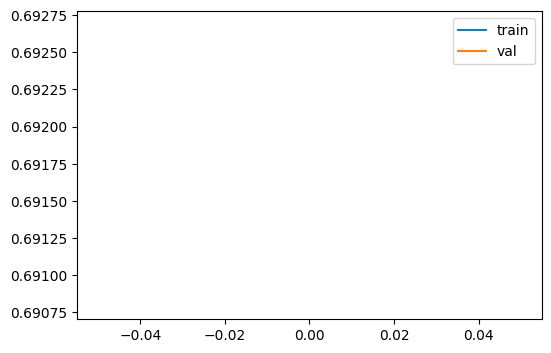

In [ ]:
plot_train_val_loss(lgcn_stats)

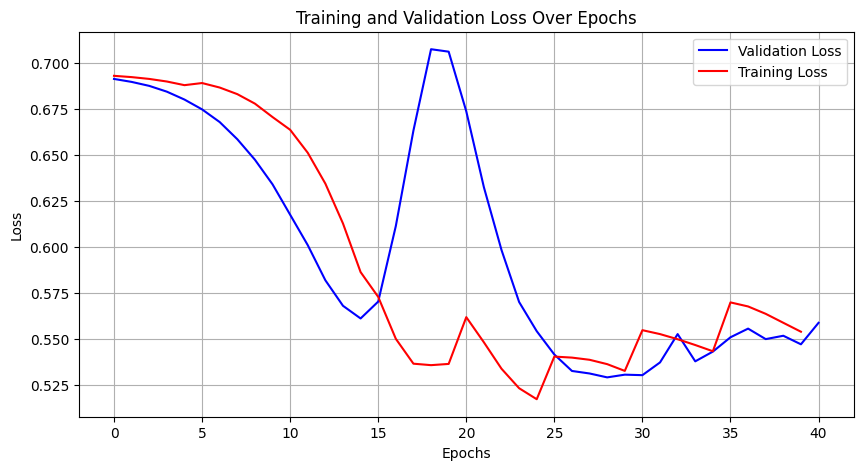

In [ ]:
val_losses = [
    0.6911334991455078, 0.6895185708999634, 0.687362015247345, 0.6842163801193237,
    0.6799306273460388, 0.6745901703834534, 0.6677061915397644, 0.6583903431892395,
    0.6472489833831787, 0.6338964104652405, 0.6173794269561768, 0.6008480787277222,
    0.581760823726654, 0.567903995513916, 0.5610204935073853, 0.5701824426651001,
    0.6112377643585205, 0.6631003618240356, 0.707270622253418, 0.7059404850006104,
    0.6735332608222961, 0.6323049068450928, 0.5982109904289246, 0.5699635744094849,
    0.5541127920150757, 0.5414323806762695, 0.5325076580047607, 0.5311363935470581,
    0.5290209054946899, 0.5304935574531555, 0.5302248597145081, 0.5371443033218384,
    0.5525323748588562, 0.5377349853515625, 0.5430207252502441, 0.5508017539978027,
    0.5555079579353333, 0.5498046278953552, 0.5516301393508911, 0.5469865202903748,
    0.5586684942245483
]

train_losses = [0.6928179264068604, 0.6921218633651733, 0.6911371350288391, 0.6897317171096802, 0.6877481937408447, 0.6888961791992188, 0.6864567399024963, 0.682876467704773, 0.6777170300483704, 0.6704267263412476, 0.6635075807571411, 0.6510148644447327, 0.6342572569847107, 0.612615168094635, 0.5862109065055847, 0.5727357268333435, 0.5499672293663025, 0.5364547371864319, 0.5356606841087341, 0.5363309383392334, 0.5617362260818481, 0.5480700731277466, 0.5337129235267639, 0.523133397102356, 0.5171557068824768, 0.5403133630752563, 0.5397586822509766, 0.5385764241218567, 0.5362125635147095, 0.5325426459312439, 0.5546562075614929, 0.5525323748588562, 0.5497418642044067, 0.5465958714485168, 0.5432107448577881, 0.5697457790374756, 0.5675458908081055, 0.5635402202606201, 0.5586684942245483, 0.5538194179534912]

# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(range(len(val_losses)), val_losses, color='b', label='Validation Loss')
plt.plot(range(len(train_losses)), train_losses, color='r', label='Training Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
recallk = [0.22439436614513397,
 0.23512442409992218,
 0.24271389842033386,
 0.2479897439479828,
 0.2535282373428345,
 0.25765174627304077,
 0.2594798505306244,
 0.26098528504371643,
 0.2621240019798279,
 0.260772705078125,
 0.2590273320674896,
 0.2589607834815979,
 0.2591300308704376,
 0.2591066360473633,
 0.26149293780326843,
 0.2641370892524719,
 0.2714138329029083,
 0.28199008107185364,
 0.2962856590747833,
 0.30534911155700684,
 0.31379884481430054,
 0.3206682503223419,
 0.3297232985496521,
 0.3317621946334839,
 0.33376556634902954,
 0.33526352047920227,
 0.33608762311935425,
 0.33825624465942383,
 0.3398362236022949,
 0.3404719924926758,
 0.3433375332355499,
 0.34533323764801025,
 0.3464357705116272,
 0.349351544857025,
 0.35156676864624023,
 0.35675841450691223,
 0.3682957971096039,
 0.37040952682495117,
 0.3819627046585083,
 0.3835173428058624]

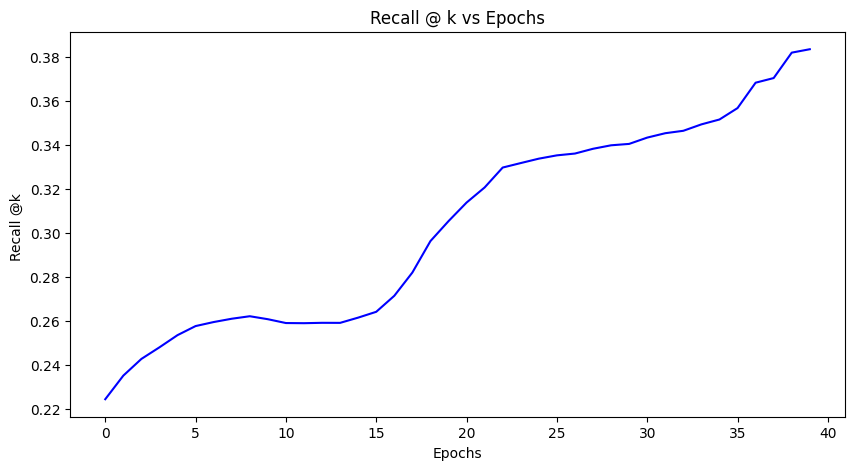

In [ ]:
# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(range(len(recallk)), recallk, color='b')
plt.title('Recall @ k vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall @k ')
plt.show()

In [ ]:
print("Predicted Scores:", preds[:100])
print("Labels:", labels[np.argsort(-preds)][:100])

In [ ]:
print(lgcn_stats['train']['loss'])

In [ ]:
l

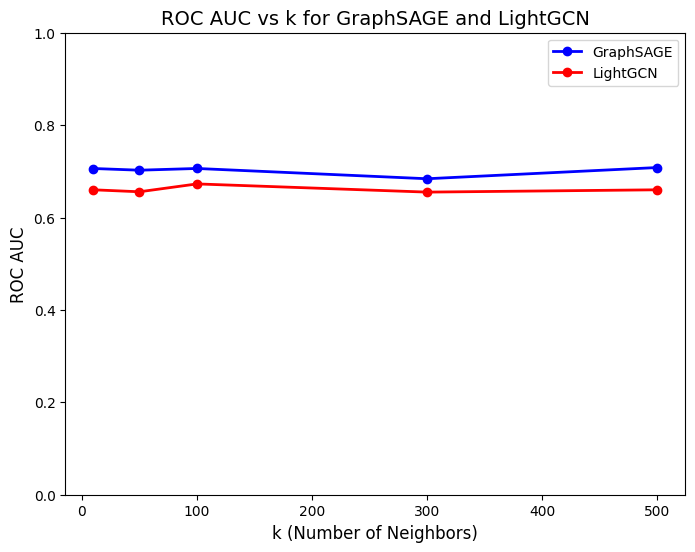

In [ ]:

# Data for GraphSAGE
k_sage = [10, 50, 100, 300, 500]
roc_sage = [0.7061022811225286, 0.7024387202884442, 0.7061730472543717,
            0.6839305592147267, 0.708172082120065]

# Data for LightGCN
k_lightgcn = [10, 50, 100, 300, 500]
roc_lightgcn = [0.66, 0.6557399385517697, 0.6727467165098252,
                0.655, 0.66]

# Plotting the ROC curves
plt.figure(figsize=(8, 6))

# GraphSAGE ROC curve
plt.plot(k_sage, roc_sage, marker='o', label='GraphSAGE', color='b', linestyle='-', linewidth=2)

# LightGCN ROC curve
plt.plot(k_lightgcn, roc_lightgcn, marker='o', label='LightGCN', color='r', linestyle='-', linewidth=2)

# Setting the axis limits
plt.ylim(0, 1)

# Adding labels and title
plt.xlabel('k (Number of Neighbors)', fontsize=12)
plt.ylabel('ROC AUC', fontsize=12)
plt.title('ROC AUC vs k for GraphSAGE and LightGCN', fontsize=14)

# Displaying legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
import numpy as np

def dcg_at_k(scores, k=500):
    """
    Compute Discounted Cumulative Gain (DCG) at rank K.
    Args:
        scores (list or np.ndarray): Relevance scores.
        k (int): Rank cutoff.
    Returns:
        float: DCG value.
    """
    scores = np.asfarray(scores)[:k]
    if scores.size:
        return np.sum(scores / np.log2(np.arange(2, scores.size + 2)))
    return 0.0

def ndcg_at_k(labels, preds, k=200):
    """
    Compute Normalized Discounted Cumulative Gain (NDCG) at rank K.
    Args:
        labels (list or np.ndarray): Ground truth relevance (binary: 0 or 1).
        preds (list or np.ndarray): Predicted scores (continuous between 0 and 1).
        k (int): Rank cutoff.
    Returns:
        float: NDCG value.
    """
    # Convert preds and labels to NumPy arrays if they aren't already
    labels = np.array(labels)
    preds = np.array(preds)

    # Sort predictions in descending order
    order = np.argsort(-preds)
    sorted_labels = labels[order]  # Align labels with sorted predictions

    # Compute DCG and Ideal DCG
    dcg = dcg_at_k(sorted_labels, k)
    ideal_dcg = dcg_at_k(sorted(sorted_labels, reverse=True), k)

    # Handle edge case where ideal DCG is 0
    return dcg / ideal_dcg if ideal_dcg > 0 else 0.0

# Debug function to check predictions and NDCG computation
def debug_ndcg(labels, preds, k=1):
    """
    Debug NDCG computation by printing intermediate values.
    Args:
        labels (list or np.ndarray): Ground truth relevance.
        preds (list or np.ndarray): Predicted scores.
        k (int): Rank cutoff.
    """
    labels = np.array(labels)
    preds = np.array(preds)

    print("Original Labels:", labels)
    print("Original Predictions:", preds)

    # Sort predictions and align labels
    order = np.argsort(-preds)
    sorted_preds = preds[order]
    sorted_labels = labels[order]

    print("Sorted Predictions:", sorted_preds)
    print("Sorted Labels:", sorted_labels)

    # Compute NDCG
    ndcg = ndcg_at_k(sorted_preds, sorted_labels, k)
    print(f"NDCG@{k}: {ndcg}")
    return ndcg

# Example usage
labels = [1, 0, 1, 0, 1]  # Binary relevance
preds = [0.9, 0.6, 0.8, 0.6, 0.7]  # Predicted scores
k = 3

# Compute NDCG and debug
debug_ndcg(labels, preds, k)


In [ ]:
labels = np.array([1, 1, 0, 0, 0, 0])
preds = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

print("NDCG@3:", ndcg_at_k(labels, preds, k=3))  # Expect close to 0.0
print("NDCG@6:", ndcg_at_k(labels, preds, k=6))  # Expect close to 0.0
